In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
from scipy.misc import imresize, imrotate
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
import keras.backend as K
from keras import models
from keras.callbacks import ModelCheckpoint
from time import gmtime, strftime
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

root_dir = os.path.abspath('..')
%matplotlib inline

Using TensorFlow backend.


In [2]:
def fetch_real_data(base_dir,num_subjects):
    '''Load in simulated data and motion files.'''
    subject_list = os.listdir((os.path.join(base_dir)))
    subject_list = [item for item in subject_list if item.startswith('sub') == True] #Filter everything but subjects
    subject_list = sorted(subject_list) #sort in numerical order to make OS independent
    counter = 0
    num_vols=172
    X = np.zeros((num_vols*num_subjects,128,128,64))
    y = np.zeros(num_vols*num_subjects)
    X_subject = np.zeros((128,128,64,num_vols))
    y_subject = np.zeros(num_vols)
    for subject_index, subject_number in enumerate(subject_list):
        if subject_index < num_subjects:
            data_path = os.path.join(base_dir,subject_number,'dwi.nii.gz')
            if os.path.isfile(data_path):
                data_header = nib.load(data_path)
                X_subject = data_header.get_data()
                y_subject = np.load(os.path.join(base_dir,subject_number,'y_manual.npy'))
                start_index = counter*num_vols
                end_index = (counter+1)*num_vols
                X[start_index:end_index,:] = np.moveaxis(X_subject,3,0)
                y[start_index:end_index] = y_subject
                counter += 1
    return X,y

def preprocess_data_coronal(X,target_height=299,target_width=299, base_slice=64,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[3]
    num_slices = X.shape[2]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,:,slices[j],:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        percentile =np.percentile(X_preprocessed,99.9)
        X_preprocessed[X_preprocessed>percentile] = percentile
        X_preprocessed/=percentile
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def preprocess_data_saggital(X,target_height=299,target_width=299, base_slice=64,rescale=False,):
    '''Convert each MR volume to three slices through a single plane, scales the data and resamples
    to 299 by 299 pixels. Optionally performs augmentation.'''   
    #slices = [22,36,50] #Planes to slice
    slices = np.array([base_slice,base_slice,base_slice]) #Planes to slice
    pad_max = np.max([X.shape[1],X.shape[3]]) #Width to pad images to
    
    num_volumes = X.shape[0]
    height = X.shape[1]
    width = X.shape[2]
    num_slices = X.shape[3]
    X_preprocessed = np.zeros((num_volumes,target_height,target_width,3))

    for i in range(num_volumes):
        for j in range(3):
            if (j == 0):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
            if (j == 1):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))
            if (j == 2):
                X_preprocessed[i,:,:,j] = imresize(pad_image(np.squeeze(X[i,slices[j],:,:]),pad_max),(target_width,target_height))     
   
    if rescale == True:
        X_preprocessed = X_preprocessed.astype(np.float32)
        X_preprocessed/= 255
        percentile =np.percentile(X_preprocessed,99.9)
        X_preprocessed[X_preprocessed>percentile] = percentile
        X_preprocessed/=percentile
        X_preprocessed -= 0.5
        X_preprocessed *= 2.
    return X_preprocessed

def pad_image(image,pad_max):
    if pad_max == 0:
        return image
    else:
        pad_width = np.array([[pad_max,pad_max],[pad_max,pad_max]])-[image.shape,image.shape]
        pad_width=np.transpose(pad_width)
        pad_width[:,0] = np.floor(pad_width[:,0]/2)
        pad_width[:,1] = np.ceil(pad_width[:,1]/2)
        return np.lib.pad(image,pad_width,'constant',constant_values=(0))
    
def preprocess_input_scaling(x):
        x=x.astype(np.float32)
        x /= 255.
        percentile =np.percentile(x,99.9)
        x[x>percentile] = percentile
        x/=percentile
        x -= 0.5
        x *= 2.
        return x

In [9]:
view = 'coronal'
#view = 'saggital'


X,y = fetch_real_data('../data/sourcedata/',7)
print(X.shape,y.shape)

num_vols = 172
num_train = 5
num_test = 2
slices_to_extract = [50,64,80]

X_train = np.zeros((num_vols*num_train*len(slices_to_extract),299,299,3))
X_test = np.zeros((num_vols*num_test*len(slices_to_extract),299,299,3))
y_train = np.zeros((num_vols*num_train*len(slices_to_extract)))
y_test = np.zeros((num_vols*num_test*len(slices_to_extract)))

for slice_num, slice_indx in enumerate(slices_to_extract):
    start_indx_train = slice_num * num_vols*num_train
    end_indx_train = (slice_num+1) * num_vols*num_train
    start_indx_test = slice_num * num_vols*num_test
    end_indx_test = (slice_num+1) * num_vols*num_test
    if view == 'saggital':
        X_preprocessed = preprocess_data_saggital(X,base_slice=slice_indx)
    elif view == 'coronal':
        X_preprocessed = preprocess_data_coronal(X,base_slice=slice_indx)
    else:
        print('View not recognised')    
    X_train[start_indx_train:end_indx_train,:] = X_preprocessed[:num_vols*num_train]
    X_test[start_indx_test:end_indx_test,:] = X_preprocessed[num_vols*num_train:]
    y_train[start_indx_train:end_indx_train]= y[:num_vols*num_train]
    y_test[start_indx_test:end_indx_test]=y[num_vols*num_train:]

y_train = (y_train!=0)
y_test = (y_test!=0)

print('Train shape X',X_train.shape)
print('Train shape y',X_train.shape)

print('Test shape X',X_test.shape)
print('Test shape y',y_test.shape)



(1204, 128, 128, 64) (1204,)
Train shape X (2580, 299, 299, 3)
Train shape y (2580, 299, 299, 3)
Test shape X (1032, 299, 299, 3)
Test shape y (1032,)


1.0


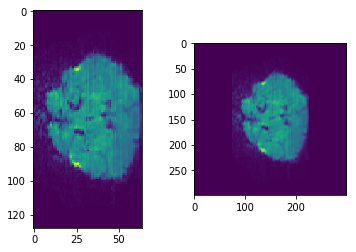

In [10]:
slice_=60
X_plot = preprocess_data_coronal(X[:,:,:,:],base_slice=slice_)

pos_indices = np.where(y!=0)[0]
index=50
index2 = pos_indices[index]

plt.subplot(1,2,1)
plt.imshow(X[index2,:,slice_,:])
plt.subplot(1,2,2)
plt.imshow(X_plot[index2,:,:,0])
print(y[index2])

In [11]:
train_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input_scaling,
    data_format='channels_last')

validation_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-6,
    rotation_range=0.,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=preprocess_input_scaling,
    data_format='channels_last',)

train_batch_size = 43
validation_batch_size = 43
train_examples = X_train.shape[0]
validation_examples = X_test.shape[0]
train_data = train_generator.flow(X_train,to_categorical(y_train,2),batch_size=train_batch_size,shuffle=True)
validation_data = validation_generator.flow(X_test,to_categorical(y_test,2),batch_size=validation_batch_size,shuffle=False)


#     ctr = 0
#     for batch in train_data:
#         im = np.squeeze(batch[0][6,:])
#         print(im.shape)
#         plt.imshow(im)
#         ctr += 1
#         if ctr > 0:
#             break

In [12]:
print(1-np.sum(y_train)/len(y_train))
print(np.sum(y_train))
print(1-np.sum(y_test)/len(y_test))
print(np.sum(y_test))


0.860465116279
360
0.758720930233
249


In [13]:
#Set up inception v3 for transfer learning
base_model = InceptionV3(weights='imagenet',include_top=False)

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(16,activation='relu')(x)
predictions = Dense(2,activation='softmax')(x)

model = Model(inputs=base_model.input,outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
             loss='binary_crossentropy',
                 metrics=['accuracy'])

In [15]:
now = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
filename = 'keras_logs/real_'+now+'.epoch{epoch:02d}-lossval{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filename,
                            period=10)

train_steps_per_epoch = train_examples/train_batch_size
validation_steps_per_epoch = validation_examples/validation_batch_size
print(train_steps_per_epoch)
print(validation_steps_per_epoch)
num_epochs = 30




print('Model name:','real_keras_logs/'+now)
history = model.fit_generator(generator = train_data,
                           steps_per_epoch=train_steps_per_epoch,
                           epochs = num_epochs,
                           validation_data = validation_data,
                           validation_steps = validation_steps_per_epoch,
                           class_weight=[1,5],
                            callbacks=[checkpoint])

validation_data = validation_generator.flow(X_test,to_categorical(y_test,2),batch_size=validation_batch_size,shuffle=False)
y_pred = model.predict_generator(validation_data,validation_steps_per_epoch)[:,1] > 0.5
print(confusion_matrix(y_test,y_pred))

60.0
24.0
Model name: real_keras_logs/2017-10-13-15-00-08
Epoch 1/30
60/60 [==============================] - 62s - loss: 0.2884 - acc: 0.8752 - val_loss: 0.4118 - val_acc: 0.7762
Epoch 2/30
60/60 [==============================] - 60s - loss: 0.1929 - acc: 0.9264 - val_loss: 0.4898 - val_acc: 0.7839
Epoch 3/30
60/60 [==============================] - 61s - loss: 0.1702 - acc: 0.9450 - val_loss: 0.4664 - val_acc: 0.7897
Epoch 4/30
60/60 [==============================] - 61s - loss: 0.1638 - acc: 0.9558 - val_loss: 0.3882 - val_acc: 0.8227
Epoch 5/30
60/60 [==============================] - 61s - loss: 0.1514 - acc: 0.9589 - val_loss: 0.4193 - val_acc: 0.8043
Epoch 6/30
60/60 [==============================] - 61s - loss: 0.1355 - acc: 0.9640 - val_loss: 0.2780 - val_acc: 0.8934
Epoch 7/30
60/60 [==============================] - 61s - loss: 0.1290 - acc: 0.9667 - val_loss: 0.2702 - val_acc: 0.9031
Epoch 8/30
60/60 [==============================] - 61s - loss: 0.1225 - acc: 0.9682 - v

In [21]:
#predictions_combined = np.concatenate((model_predictions_coronal_test,model_predictions_saggital_test),axis=1)
predictions_combined = model_predictions_saggital_test
y_pred = np.mean(predictions_combined,axis=1)>0.6
print(classification_report((y_test!=0),y_pred))
print(confusion_matrix((y_test!=0),y_pred))

             precision    recall  f1-score   support

      False       0.99      0.98      0.98       295
       True       0.88      0.94      0.91        49

avg / total       0.97      0.97      0.97       344

[[289   6]
 [  3  46]]


# Visualise 

In [ ]:
#Load back in results
y_predictions_combined = np.load('misc_files/predictions_combined_val.npy')
y_val = np.load('misc_files/y_val.npy')
svm_classifier = joblib.load('misc_files/svm_classifier.pkl') 
#y_pred_val = svm_classifier.predict(y_predictions_combined)
y_pred_val = np.mean(y_predictions_combined,axis=1) > 0.5 
print(confusion_matrix(y_val,y_pred_val))


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import animation
from matplotlib import animation, rc
from IPython.display import HTML


ind_true_pos = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 1) and (y_pred_val[indx] == 1) ]
ind_true_neg = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 0) and (y_pred_val[indx] == 0) ]
ind_false_neg = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 1) and (y_pred_val[indx] == 0) ]
ind_false_pos = [indx for indx,y in enumerate(y_val) if (y_val[indx] == 0) and (y_pred_val[indx] == 1) ]

In [ ]:
#Animated plot of confusion-matrix
#X, y = fetch_data(os.path.join(root_dir,'data/sims'),8)
X_test_preprocessed = preprocess_data_planar(X[648:,:,:,:])
#del X, y

X_test_preprocessed_plot = X_test_preprocessed.astype(np.float32)/255
#X_test_preprocessed_plot += 0.5

fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

image1 = ax1.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax1.axis('off')
image2 = ax2.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax2.axis('off')
image3 = ax3.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax3.axis('off')
image4 = ax4.imshow(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2],3))); ax4.axis('off')
fig.text(0.5, 0.94, 'Predictions', ha='center',weight='bold')
fig.text(0.06, 0.5, 'Actual', ha='center',weight='bold')
fig.text(0.08, 0.7, 'False', ha='center')
fig.text(0.08, 0.3, 'True', ha='center')
fig.text(0.32, 0.9, 'False', ha='center')
fig.text(0.7, 0.9, 'True', ha='center')
fig.text(0.47, 0.52, str(len(ind_true_neg)), ha='center',color='white')
fig.text(0.55, 0.52, str(len(ind_false_pos)), ha='center',color='white')
fig.text(0.47, 0.45, str(len(ind_false_neg)), ha='center',color='white')
fig.text(0.55, 0.45, str(len(ind_true_pos)), ha='center',color='white')

matplotlib.rcParams.update({'font.size': 20})
fig.subplots_adjust(hspace=0.03, wspace=0.02)
plt.close()

def init():
    image1.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2]))); 
    image2.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    image3.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    image4.set_data(np.zeros((X_test_preprocessed_plot.shape[1],X_test_preprocessed_plot.shape[2])))
    
    return image1,image2,image3,image4,

def animate(i):
    image1.set_data(np.rot90(X_test_preprocessed_plot[ind_true_neg[i % len(ind_true_neg)],:]))
    image2.set_data(np.rot90(X_test_preprocessed_plot[ind_false_pos[i % len(ind_false_pos)],:]))
    image3.set_data(np.rot90(X_test_preprocessed_plot[ind_false_neg[i % len(ind_false_neg)],:]))
    image4.set_data(np.rot90(X_test_preprocessed_plot[ind_true_pos[i % len(ind_true_pos)],:]))
    return image1,image2,image3,image4,

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=40,interval=200,blit=True)
mywriter = animation.FFMpegWriter()
HTML(anim.to_html5_video())

In [ ]:
#import matplotlib
#import matplotlib.pyplot as plt
print(y_test)
plt.plot(np.linspace(25,54,30),model_predictions[n])
plt.title('True:'+str(y_test[n])+' Predicted:'+str(y_pred[n]))

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

In [ ]:
#Look at memory usage of all items in notebook
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [ ]:
import keras
print(keras.__version__)